## 187 - National LCL Map Part 2

[Youtube](https://www.youtube.com/watch?v=00oGuWTb0hY)

In [1]:
from datetime import datetime
from metpy.units import units
from siphon.simplewebservice.iastate import IAStateUpperAir
import pandas as pd

In [2]:
date = datetime(2021, 6, 13, 0)

In [3]:
df = IAStateUpperAir.request_all_data(date)

In [4]:
df.head()

,pressure,height,temperature,dewpoint,direction,speed,station,time,u_wind,v_wind
0,963.0,386.0,19.4,14.4,265.0,8.0,CWPL,2021-06-13,7.969558,6.972459e-01
1,957.0,439.0,18.6,12.6,NaN,NaN,CWPL,2021-06-13,NaN,NaN
2,951.0,493.0,18.0,13.0,NaN,NaN,CWPL,2021-06-13,NaN,NaN
3,938.2,609.0,NaN,NaN,270.0,11.0,CWPL,2021-06-13,11.000000,2.020667e-15
4,925.0,730.0,16.0,11.2,280.0,20.0,CWPL,2021-06-13,19.696155,-3.472964e+00


In [5]:
df.tail()

,pressure,height,temperature,dewpoint,direction,speed,station,time,u_wind,v_wind
14578,7.5,33528.0,NaN,NaN,75.0,32.0,KYMW,2021-06-13,-30.909626,-8.282209
14579,7.0,34030.0,-30.3,-64.3,115.0,24.0,KYMW,2021-06-13,-21.751387,10.142838
14580,6.4,34667.0,-29.5,-63.5,NaN,NaN,KYMW,2021-06-13,NaN,NaN
14581,6.2,34893.0,-30.1,-64.1,NaN,NaN,KYMW,2021-06-13,NaN,NaN
14582,6.1,35052.0,NaN,NaN,130.0,16.0,KYMW,2021-06-13,-12.256711,10.284602


In [6]:
# ruc.noaa.gov/raobs/stat2000.txt
stations = df['station'].unique()
stations
len(stations)

113

In [7]:
df_locations = pd.read_csv('https://ruc.noaa.gov/raobs/stat2000.txt', delim_whitespace = True, skiprows = 1, usecols = [0, 3, 4], names = ['station', 'lat', 'lon'])
df_locations.head()

,station,lat,lon
0,NPC,14.05,83.57
1,EPZ,31.90,106.70
2,DRA,36.93,116.07
3,DRA,36.60,115.97
4,DRA,36.95,116.05


In [8]:
stations_with_location = []
for s in stations:
 stn_id = s[1:]
 if stn_id in df_locations['station'].values:
  stations_with_location.append(s)
 else:
  print(f'No location for station {stn_id}')

No location for station SYA


In [9]:
len(stations_with_location)

112

In [10]:
import metpy.calc as mpcalc
import numpy as np

In [11]:
stations = []
lats = []
lons = []
lcl_pressures = []
lcl_temperatures = []

for s in stations_with_location:
 data = df[df['station'] == s]
 idx = data['pressure'].idxmax()
 sfc_temp = data['temperature'][idx] * units.degC
 sfc_dewp = data['dewpoint'][idx] * units.degC
 sfc_pres = data['pressure'][idx] * units.hPa

 try:
  lcl_pres, lcl_temp = mpcalc.lcl(sfc_pres, sfc_temp, sfc_dewp)
  stn_id = s[1:]
  _, lat, lon = df_locations[df_locations['station'] == stn_id].values[0]
  stations.append(s)
  lats.append(lat)
  lons.append(-lon)
  lcl_pressures.append(lcl_pres.m)
  lcl_temperatures.append(lcl_temp.m)

 except RuntimeError:
  print(f'Failure for station {s}')

In [12]:
lcl_pressures

[894.0626154778957,
 971.7486896258741,
 694.5165827343895,
 766.0618153521041,
 897.5772434870901,
 969.1801395036003,
 959.9884144806176,
 928.9048599411018,
 990.2413101866263,
 830.2225970894655,
 937.2088389319623,
 865.2393638880005,
 979.9260033563219,
 797.6059264662163,
 982.0436615442642,
 891.578234249826,
 970.2116889403305,
 877.4588969005625,
 890.7514821082319,
 930.9137622305353,
 974.6931656620411,
 762.2582564634531,
 799.4536458397013,
 495.67445153339537,
 690.9145156345429,
 923.1409817716286,
 949.4932258233497,
 824.6865376821679,
 771.6710094228098,
 799.8417998513153,
 952.3546174004624,
 890.8951170630455,
 921.1421254790943,
 661.4744166498241,
 935.4394572672655,
 830.6781319066432,
 662.1398395137596,
 900.603241169931,
 1005.9763318438655,
 778.0172085077728,
 697.8948242654122,
 1007.3835221085465,
 899.8575749792543,
 722.2646645548077,
 nan,
 nan,
 889.5166683504603,
 746.7831237746218,
 474.2376979019505,
 913.4213728998926,
 830.5594495576202,
 899.89

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

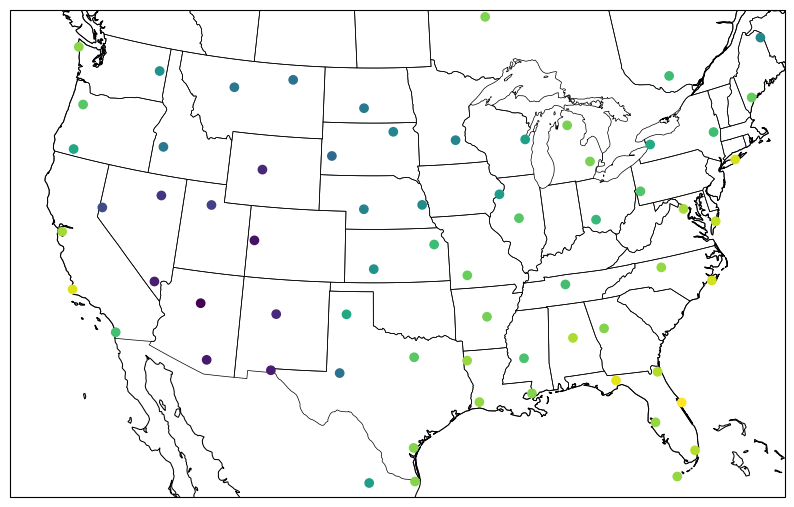

In [14]:
crs = ccrs.LambertConformal(central_longitude = -100, central_latitude = 45)
bounds = [(-122, -75, 25, 50)]

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1, 1, 1, projection = crs)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth = 0.75)
ax.add_feature(cfeature.STATES, linewidth = 0.5)

ax.scatter(lons, lats, c = lcl_pressures, transform = ccrs.PlateCarree())

ax.set_extent(*bounds, crs = ccrs.PlateCarree())

In [15]:
from metpy.interpolate import interpolate_to_grid

In [16]:
lats = np.array(lats)
lons = np.array(lons)
lcl_pressures = np.array(lcl_pressures)

interpx, interpy, interpz = interpolate_to_grid(lons, lats, lcl_pressures, interp_type = 'natural_neighbor', hres = 0.5)  # interp_type = 'cressman' on original script

/home/jessica/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


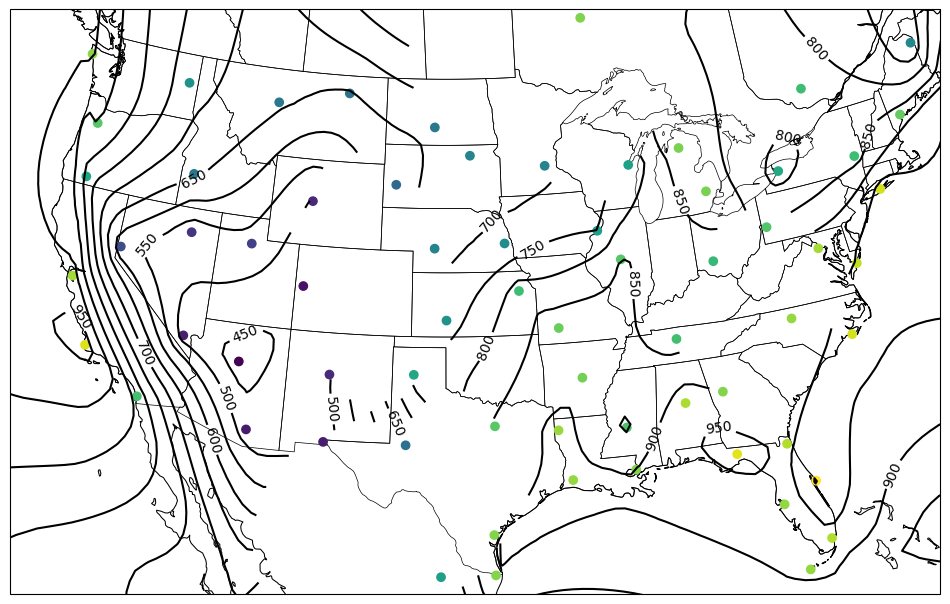

In [17]:
fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(1, 1, 1, projection = crs)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth = 0.75)
ax.add_feature(cfeature.STATES, linewidth = 0.5)

ax.scatter(lons, lats, c = lcl_pressures, transform = ccrs.PlateCarree())

ax.set_extent(*bounds, crs = ccrs.PlateCarree())

cs = ax.contour(interpx, interpy, interpz, colors = 'k', linewidth = 1, linestyles = 'solid', transform = ccrs.PlateCarree(), levels = np.arange(300, 1200, 50))

ax.clabel(cs)